In [1]:
import numpy as np
import os
import pandas as pd
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [2]:
os.chdir('../')

In [3]:
df_train = pd.read_csv('./data/processed/train.csv', sep = ';', decimal=',')

In [4]:
df_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine,date
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-08
1,1466964,1,55,1993,136.83,135.83,0,0,270,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-08
2,1346989,1,55,2539,134.86,135.86,0,0,189,647,56,TYPE_C,2.0,Beverages,Thai,2017-01-08
3,1338232,1,55,2139,339.50,437.53,0,0,54,647,56,TYPE_C,2.0,Beverages,Indian,2017-01-08
4,1448490,1,55,2631,243.50,242.50,0,0,40,647,56,TYPE_C,2.0,Beverages,Indian,2017-01-08


In [7]:
center_id = 55
meal_id = 1993

In [8]:
from src.model.xgboost_model import preprocess_data, train_xgboost_model

In [9]:
df_train_processed = preprocess_data(df_train, center_id, meal_id)

/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/home/jupyter/tfg-sb-meal-delivery-prediction/src/model/xgboost_model.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_processed['day'] = df_processed.date.dt.day
/home/jupyter/tfg-sb-meal-delivery-prediction/src/model/xgboost_model.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [10]:
df_train_processed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 145 entries, 2017-01-01 to 2019-10-06
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   week                   145 non-null    int64  
 1   checkout_price         145 non-null    float64
 2   base_price             145 non-null    float64
 3   emailer_for_promotion  145 non-null    int64  
 4   homepage_featured      145 non-null    int64  
 5   num_orders             145 non-null    int64  
 6   city_code              145 non-null    int64  
 7   region_code            145 non-null    int64  
 8   op_area                145 non-null    float64
 9   day                    145 non-null    int64  
 10  month                  145 non-null    int64  
 11  year                   145 non-null    int64  
 12  quarter                145 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 15.9 KB


# XGBoost

In [11]:
xgb_model, rmse = train_xgboost_model(df_train_processed)

RMSE: 45.64661830504204


In [15]:
X = df_train_processed.drop(columns='num_orders')
Y = np.log1p(df_train_processed['num_orders'])

split_size = len(df_train_processed) - 15
X_train = X.iloc[:split_size,:]
X_test = X.iloc[split_size:,:]
Y_train =  Y.iloc[:split_size]
Y_test = Y.iloc[split_size:]

In [16]:
xgb_preds = xgb_model.predict(X_test)

In [17]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)
xgb_preds = np.exp(xgb_preds)

In [18]:
xgb_preds = pd.DataFrame(xgb_preds)
xgb_preds.index = Y_test.index

In [19]:
import matplotlib.pyplot as plt

In [22]:
xgb_preds.sort_index()

,0
date,
2019-06-30,144.900391
2019-07-07,159.391495
2019-07-14,152.225510
2019-07-21,145.160065
2019-07-28,150.961151
2019-08-04,149.051590
2019-08-11,131.314651
2019-08-18,142.734955
2019-08-25,151.963547


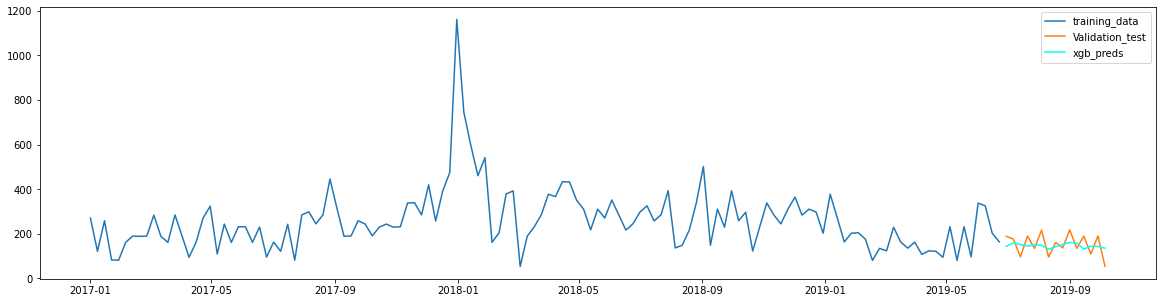

In [20]:
plt.figure(figsize=(20,5))
plt.plot(Y_train.sort_index(), label='training_data')
plt.plot(Y_test.sort_index(), label='Validation_test')
plt.plot(xgb_preds.sort_index(), color='cyan', label='xgb_preds')
plt.legend(loc='best')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

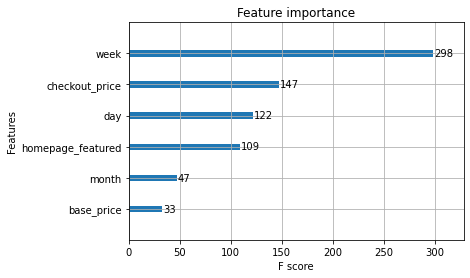

In [23]:
xgb.plot_importance(xgb_model)

# Light GBM Model

In [25]:
from lightgbm import LGBMRegressor

In [26]:
lgb_fit_params={
	"early_stopping_rounds" : 500, 
	"eval_metric" : 'rmse', 
	"eval_set" : [(X_test, Y_test)],
	'eval_names': ['valid'],
	'verbose' : 20
}

In [27]:
lgb_params = {
	'boosting_type': 'gbdt',
	'objective': 'regression',
	'metric': 'rmse',
	'verbose': 0,
	'bagging_fraction': 0.8,
	'bagging_freq': 1,
	'lambda_l1': 0.01,
	'lambda_l2': 0.01,
	'learning_rate': 0.001,
	'max_bin': 255,
	'max_depth': 6,
	'min_data_in_bin': 1,
	'min_data_in_leaf': 1,
	'num_leaves': 31
}

In [28]:
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)

In [29]:
clf_lgb = LGBMRegressor(n_estimators=10000, **lgb_params, random_state=0, n_jobs=-1)

In [30]:
clf_lgb.fit(X_train, Y_train, **lgb_fit_params)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, lambda_l1=0.01,
              lambda_l2=0.01, learning_rate=0.001, max_bin=255, max_depth=6,
              metric='rmse', min_data_in_bin=1, min_data_in_leaf=1,
              n_estimators=10000, objective='regression', random_state=0,
              verbose=0)

In [31]:
lgb_model = LGBMRegressor(
	bagging_fraction=0.8, 
	bagging_freq=1, 
	lambda_l1=0.01,
	lambda_l2=0.01, 
	learning_rate=0.01, 
	max_bin=255, 
	max_depth=6,
    metric='rmse', 
	min_data_in_bin=1, 
	min_data_in_leaf=1,
    n_estimators=10000, 
	objective='regression',
    random_state=0, 
	verbose=0
)

In [32]:
lgb_model.fit(X_train,Y_train)

[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.01, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1


LGBMRegressor(bagging_fraction=0.8, bagging_freq=1, lambda_l1=0.01,
              lambda_l2=0.01, learning_rate=0.01, max_bin=255, max_depth=6,
              metric='rmse', min_data_in_bin=1, min_data_in_leaf=1,
              n_estimators=10000, objective='regression', random_state=0,
              verbose=0)

In [33]:
lgm_preds = lgb_model.predict(X_test)
lgm_preds = np.exp(lgm_preds)

In [34]:
lgm_preds = pd.DataFrame(lgm_preds)
lgm_preds.index = Y_test.index

In [35]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)

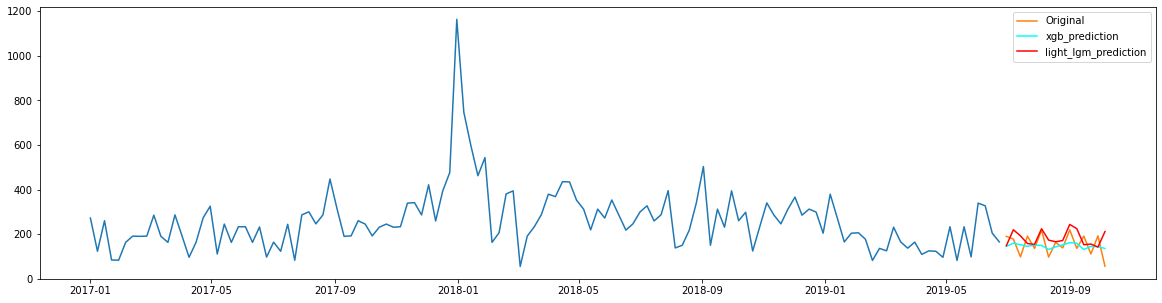

In [36]:
plt.figure(figsize=(20,5))
plt.plot(Y_train)
plt.plot(Y_test, label='Original')
plt.plot(xgb_preds, color='cyan', label="xgb_prediction")
plt.plot(lgm_preds, color='red', label='light_lgm_prediction')
plt.legend(loc='best')

# Cat Regressor

In [40]:
from catboost import CatBoostRegressor

In [41]:
Y_train = np.log1p(Y_train)
Y_test = np.log1p(Y_test)

In [42]:
cat_model=CatBoostRegressor()
cat_model.fit(X_train, Y_train)

Learning rate set to 0.027145
0:	learn: 0.0757420	total: 46.6ms	remaining: 46.6s
1:	learn: 0.0753363	total: 47.5ms	remaining: 23.7s
2:	learn: 0.0750520	total: 48.2ms	remaining: 16s
3:	learn: 0.0746086	total: 48.9ms	remaining: 12.2s
4:	learn: 0.0741300	total: 49.4ms	remaining: 9.83s
5:	learn: 0.0736976	total: 50ms	remaining: 8.28s
6:	learn: 0.0733010	total: 50.5ms	remaining: 7.17s
7:	learn: 0.0728214	total: 51ms	remaining: 6.33s
8:	learn: 0.0724083	total: 51.6ms	remaining: 5.68s
9:	learn: 0.0720163	total: 52.2ms	remaining: 5.17s
10:	learn: 0.0715594	total: 52.9ms	remaining: 4.75s
11:	learn: 0.0712028	total: 53.5ms	remaining: 4.4s
12:	learn: 0.0707709	total: 54.1ms	remaining: 4.11s
13:	learn: 0.0703557	total: 54.7ms	remaining: 3.85s
14:	learn: 0.0700074	total: 55.3ms	remaining: 3.63s
15:	learn: 0.0697716	total: 55.7ms	remaining: 3.42s
16:	learn: 0.0694968	total: 56ms	remaining: 3.24s
17:	learn: 0.0692634	total: 56.4ms	remaining: 3.08s
18:	learn: 0.0687861	total: 57ms	remaining: 2.94s
19:

In [44]:
cat_preds = cat_model.predict(X_test)
cat_preds = np.exp(cat_preds)

In [45]:
cat_preds = pd.DataFrame(cat_preds)
cat_preds.index = Y_test.index

In [46]:
Y_train = np.exp(Y_train)
Y_test = np.exp(Y_test)

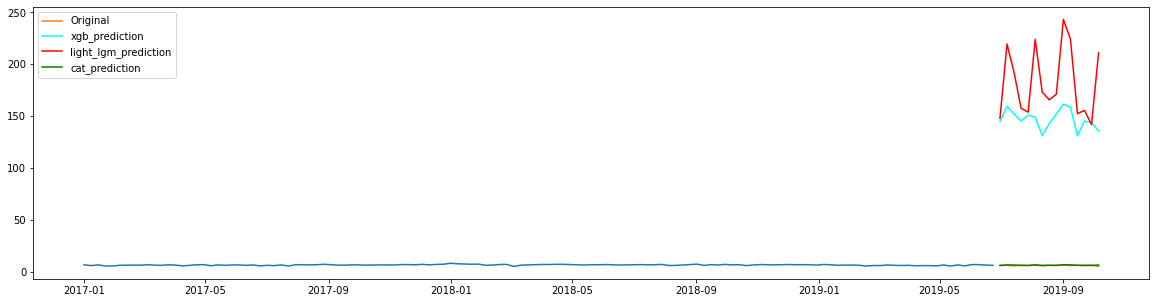

In [47]:
plt.figure(figsize=(20,5))
plt.plot(Y_train)
plt.plot(Y_test, label='Original')
plt.plot(xgb_preds, color='cyan', label="xgb_prediction")
plt.plot(lgm_preds, color='red', label='light_lgm_prediction')
plt.plot(cat_preds, color='green', label='cat_prediction')
plt.legend(loc='best')

# Linear regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [125]:
lr = LinearRegression()  
lr.fit(X_train, Y_train)

Root Mean Squared Error for LinearRegression: 108.22292251741374


In [ ]:
y_pred = lr.predict(X_test)

In [ ]:
print('Root Mean Squared Error for LinearRegression:', np.sqrt(metrics.mean_squared_error(Y_test, y_pred)))